♻️ Memory cleared.
Connecting to Drive...
Mounted at /content/drive
✅ Using device: cpu

Processing Dataset...
Classes: ['degeneration', 'fracture', 'misalignment', 'normal']

🚀 STARTING TRAINING: convnext
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:01<00:00, 81.3MB/s]


Epoch 5/25 | Train Loss: 0.9538 | Val Acc: 0.2257
Epoch 10/25 | Train Loss: 0.8329 | Val Acc: 0.7478
Epoch 15/25 | Train Loss: 0.6924 | Val Acc: 0.7389
Epoch 20/25 | Train Loss: 0.4824 | Val Acc: 0.7522
Epoch 25/25 | Train Loss: 0.4712 | Val Acc: 0.7876
✅ Finished convnext. Best Acc: 0.7920

🚀 STARTING TRAINING: effnet
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 85.9MB/s]


Epoch 5/25 | Train Loss: 0.8985 | Val Acc: 0.7168
Epoch 10/25 | Train Loss: 0.7003 | Val Acc: 0.7345
Epoch 15/25 | Train Loss: 0.5529 | Val Acc: 0.8230
Epoch 20/25 | Train Loss: 0.5080 | Val Acc: 0.8097
Epoch 25/25 | Train Loss: 0.4565 | Val Acc: 0.8274
✅ Finished effnet. Best Acc: 0.8363

⚖️ Running Ensemble Evaluation with TTA...

🏆 FINAL ENSEMBLE ACCURACY: 81.42%

Classification Report:
              precision    recall  f1-score   support

degeneration       0.81      0.72      0.76        64
    fracture       0.85      0.55      0.67        20
misalignment       0.96      0.74      0.84        31
      normal       0.79      0.94      0.86       111

    accuracy                           0.81       226
   macro avg       0.85      0.74      0.78       226
weighted avg       0.82      0.81      0.81       226



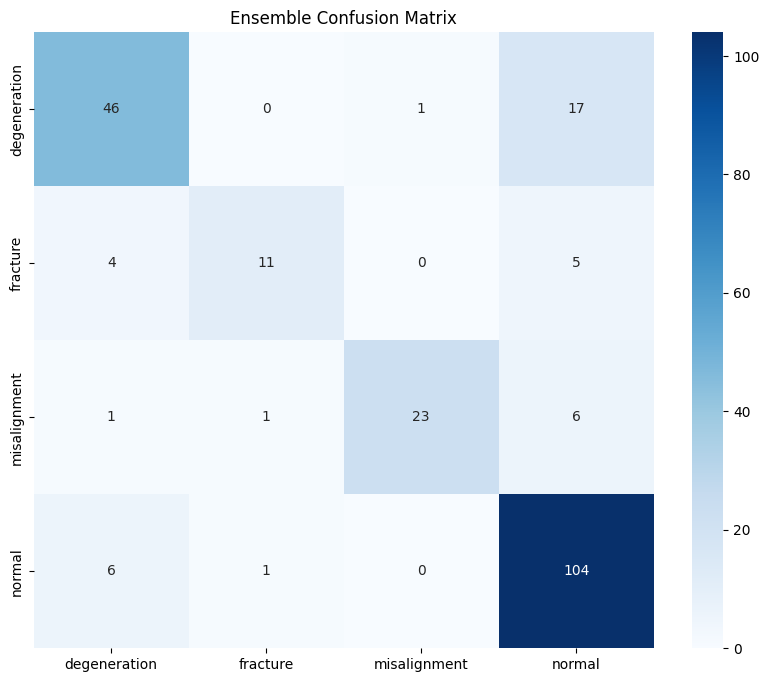

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from google.colab import drive
import numpy as np
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import copy
import time
import gc
from PIL import Image
import os

# --- 1. SETUP & CONFIG ---
gc.collect()
torch.cuda.empty_cache()
print("♻️ Memory cleared.")

print("Connecting to Drive...")
drive.mount('/content/drive')

CONFIG = {
    'data_dir': '/content/drive/MyDrive/reported_lateral',
    'save_path_convnext': '/content/drive/MyDrive/best_model_convnext.pth',
    'save_path_effnet': '/content/drive/MyDrive/best_model_effnet.pth',
    'img_size': 224,        # Standard size for ensembles
    'batch_size': 16,       # Safe for Colab
    'lr': 1e-4,             # Low & Slow for stability
    'epochs': 25,           # 25 epochs per model is sufficient
    'seed': 42
}

# Reproducibility
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# --- 2. ADVANCED PREPROCESSING (CLAHE) ---
class CLAHE_Transform:
    """Standardizes contrast to make fractures visible."""
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        img_np = np.array(img)
        if len(img_np.shape) == 2:
            img_lab = img_np
        else:
            img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        if len(img_np.shape) == 2:
            img_output = clahe.apply(img_lab)
        else:
            l, a, b = cv2.split(img_lab)
            l_enhanced = clahe.apply(l)
            img_merged = cv2.merge((l_enhanced, a, b))
            img_output = cv2.cvtColor(img_merged, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img_output)

# --- 3. DATA LOADING ---
# Training: Heavy Augmentation
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    CLAHE_Transform(),
    transforms.TrivialAugmentWide(), # SOTA Automated Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation: Clean
val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    CLAHE_Transform(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("\nProcessing Dataset...")
full_dataset = ImageFolder(CONFIG['data_dir'])
class_names = full_dataset.classes
targets = full_dataset.targets
print(f"Classes: {class_names}")

# Stratified Split (80/20)
train_idx, val_idx = train_test_split(
    np.arange(len(targets)), test_size=0.2, shuffle=True, stratify=targets, random_state=CONFIG['seed']
)

# Custom Dataset Wrapper
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self): return len(self.subset)

train_dataset = TransformedSubset(Subset(full_dataset, train_idx), transform=train_transforms)
val_dataset = TransformedSubset(Subset(full_dataset, val_idx), transform=val_transforms)

# Weighted Sampler (Crucial for Imbalance)
train_targets = [targets[i] for i in train_idx]
class_counts = Counter(train_targets)
sample_weights = [1.0 / class_counts[t] for t in train_targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=CONFIG['batch_size'], sampler=sampler, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
}

# --- 4. TRAINING FUNCTION (Generic) ---
def train_one_model(model_name, save_path):
    print(f"\n🚀 STARTING TRAINING: {model_name}")

    # Initialize Architecture
    if model_name == 'convnext':
        model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(class_names))
    elif model_name == 'effnet':
        model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))

    model = model.to(device)

    # Optimizer & Scheduler
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(dataloaders['train']), epochs=CONFIG['epochs'])

    best_acc = 0.0

    for epoch in range(CONFIG['epochs']):
        # Train
        model.train()
        train_loss = 0.0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item() * inputs.size(0)

        # Val
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_acc = val_correct.double() / len(val_dataset)

        # Save Best
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Train Loss: {train_loss/len(train_dataset):.4f} | Val Acc: {val_acc:.4f}")

    print(f"✅ Finished {model_name}. Best Acc: {best_acc:.4f}")
    del model
    del optimizer
    torch.cuda.empty_cache()
    gc.collect()

# --- 5. EXECUTE SEQUENTIAL TRAINING ---
# Train Model A (ConvNeXt)
train_one_model('convnext', CONFIG['save_path_convnext'])

# Train Model B (EfficientNet)
train_one_model('effnet', CONFIG['save_path_effnet'])

# --- 6. ENSEMBLE EVALUATION (The Magic Step) ---
print("\n⚖️ Running Ensemble Evaluation with TTA...")

# Load Models
model_a = models.convnext_tiny(weights=None)
model_a.classifier[2] = nn.Linear(model_a.classifier[2].in_features, len(class_names))
model_a.load_state_dict(torch.load(CONFIG['save_path_convnext'], map_location=device))
model_a = model_a.to(device).eval()

model_b = models.efficientnet_b3(weights=None)
model_b.classifier[1] = nn.Linear(model_b.classifier[1].in_features, len(class_names))
model_b.load_state_dict(torch.load(CONFIG['save_path_effnet'], map_location=device))
model_b = model_b.to(device).eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)

        # 1. Forward Pass (Original)
        out_a1 = model_a(inputs)
        out_b1 = model_b(inputs)

        # 2. Forward Pass (Flipped - TTA)
        inputs_flipped = torch.flip(inputs, dims=[3]) # Horizontal flip
        out_a2 = model_a(inputs_flipped)
        out_b2 = model_b(inputs_flipped)

        # 3. Average Probabilities (Soft Voting)
        # (Model A Original + Model A Flipped + Model B Original + Model B Flipped) / 4
        probs = (torch.softmax(out_a1, 1) + torch.softmax(out_a2, 1) +
                 torch.softmax(out_b1, 1) + torch.softmax(out_b2, 1)) / 4

        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 7. FINAL REPORT ---
acc = accuracy_score(all_labels, all_preds)
print(f"\n🏆 FINAL ENSEMBLE ACCURACY: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Ensemble Confusion Matrix')
plt.show()